In [6]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [7]:
# load the dataset
filename = "finaltrygood.xlsx"
df = pd.read_excel(filename)

# display first few rows of the dataset
# print(df.head())

In [8]:
# drop duplicate columns (Latitude and Longitude bc we already have latitude and longitude (lowercase))
# township and Town Code redundant because they say the same thing as township_name
# nbhd and Neighborhood Code (Mapping) and Town and Neighborhood are the same as Neighborhood Code as well
df = df.drop(columns=['Latitude', 'Longitude', 'township', 'Town Code', 'nbhd', 'Neigborhood Code (mapping)', 'Town and Neighborhood', 'Other Improvments', 'Draw1', 'Draw2', 'Draw3', 'Max'], errors='ignore')

# convert multi-family indicator into a categorical variable (replace missing values with 0)
df['Multi-Family Indicator'] = df['Multi-Family Indicator'].fillna(0)
df['Multi-Family Indicator'] = df['Multi-Family Indicator'].astype(int) # convert to integer for clarity

# drop columns with excessive null values
missing_values = df.isnull().sum()
threshold = len(df) * 0.6 # drop columns with more than 60% missing values (arbitrary threshold)
columns_to_drop = missing_values[missing_values > threshold].index
df_cleaned = df.drop(columns=columns_to_drop)

# print the dropped columns
print("Dropped columns: ", columns_to_drop)

# drop rows with missing values and print number of rows dropped
df_cleaned = df_cleaned.dropna()
print("Number of rows dropped: ", len(df) - len(df_cleaned))
print("Number of rows remaining: ", len(df_cleaned))

# check the shape of the cleaned dataset
print(df_cleaned.shape)

# print first few rows of the cleaned dataset
print(df_cleaned.head())

Dropped columns:  Index(['Renovation', 'Total Building Square Feet',
       'Condition, Desirability and Utility'],
      dtype='object')
Number of rows dropped:  10527
Number of rows remaining:  19182
(19182, 48)
         Date              Address property_city property_zip  longitude  \
0  12/10/2020   97XX S MERRION AVE       CHICAGO   60617-4846 -87.570148   
1   11/4/2020    63XX N HAMLIN AVE       CHICAGO   60659-1021 -87.723620   
2  11/21/2019     76XX S DAMEN AVE       CHICAGO   60620-5753 -87.672916   
3   3/18/2020  48XX N MERRIMAC AVE       CHICAGO   60630-2914 -87.784708   
4  10/11/2019   115XX S JUSTINE ST       CHICAGO   60643-5002 -87.659999   

    latitude township_name   tract_geoid  tract_pop  tract_white_perc  ...  \
0  41.717214     Hyde Park  1.703151e+10     5126.0          0.003512  ...   
1  41.996733     Jefferson  1.703113e+10     5228.0          0.599464  ...   
2  41.754665          Lake  1.703171e+10     5514.0          0.007617  ...   
3  41.969542     

In [9]:
# check data types of the columns
# print(df_cleaned.dtypes)

# convert 'date' column to datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce')

# convert appropriate object columns to numerica where applicable
# numeric_convert_columns = ['Draw2', 'Max']
# for col in numeric_convert_columns:
#   df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
    
# convert relevant object columns to categorical
categorical_columns = [
    'property_city', 'property_zip', 'township_name', 'commissioner_dist', 'senate_dist',
    'ward', 'school_elem_district', 'Property Class', 'Neighborhood Code', 'Type of Residence',
    'Multi-Family Indicator', 'Multi Property Indicator', 'Near Major Road', 'Garage indicator',
    'Neighborhood Code', 'Private Service Line Material', 'Public Service Line Material',
    'tract_geoid', 'PIN', 'Apartments', 'Wall Material', 'Roof Material', 'Basement', 'Basement Finish',
    'Construction Quality', 'Garage 1 Size', 'Garage 1 Material', 'Porch', 'Repair Condition',
    'Multi Code', 'Use', 'reps_dist'
]

for col in categorical_columns:
    df_cleaned[col] = df_cleaned[col].astype('category')
    
# check data types of the columns
print(df_cleaned.dtypes)

# check for any remaining missing values
# remaining_missing = df_cleaned.isnull().sum()
# print(remaining_missing)

# drop rows with missing values
df_cleaned = df_cleaned.dropna()


# final shape of dataset
print(df_cleaned.shape)


Date                                               datetime64[ns]
Address                                                    object
property_city                                            category
property_zip                                             category
longitude                                                 float64
latitude                                                  float64
township_name                                            category
tract_geoid                                              category
tract_pop                                                 float64
tract_white_perc                                          float64
commissioner_dist                                        category
reps_dist                                                category
senate_dist                                              category
ward                                                     category
school_elem_district                                     category
PIN       

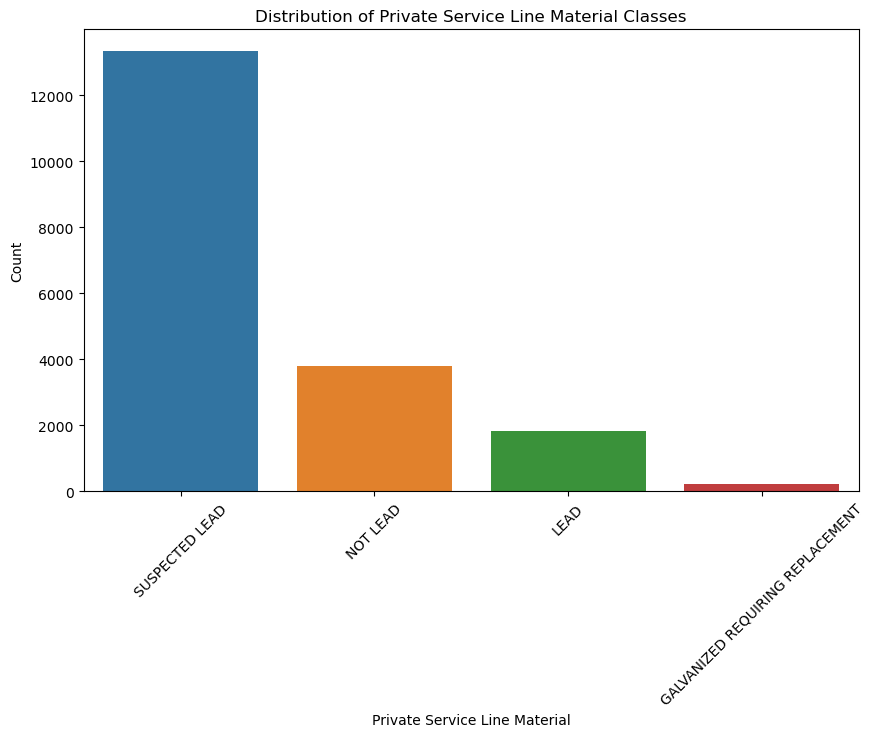

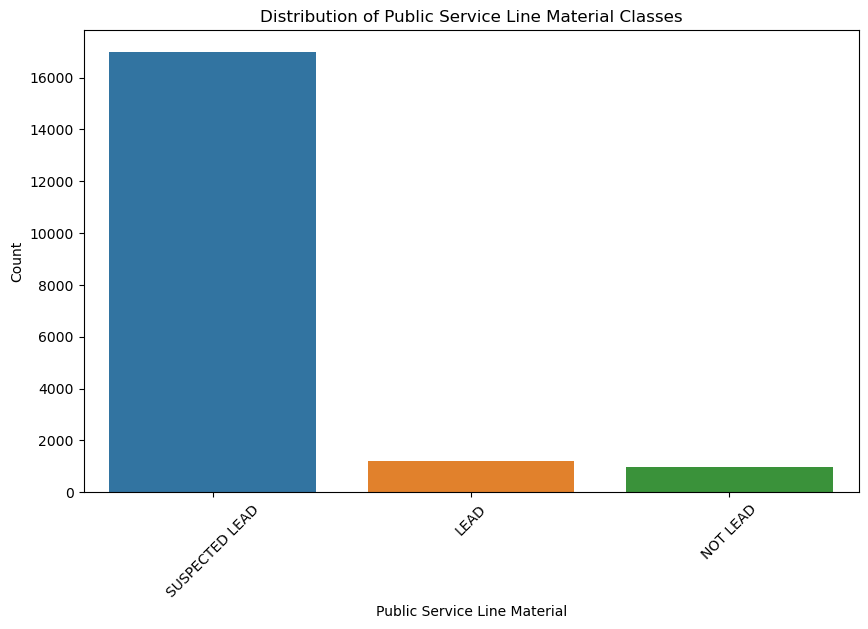

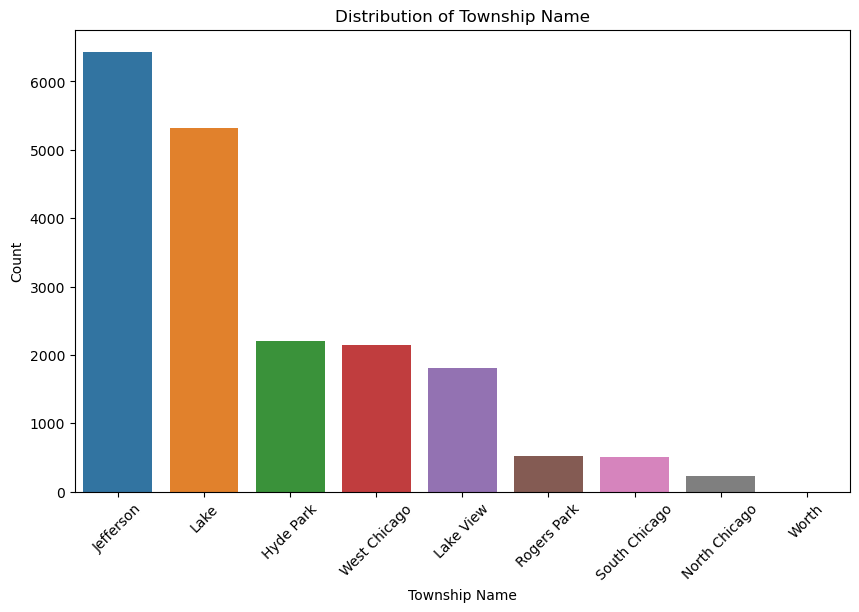

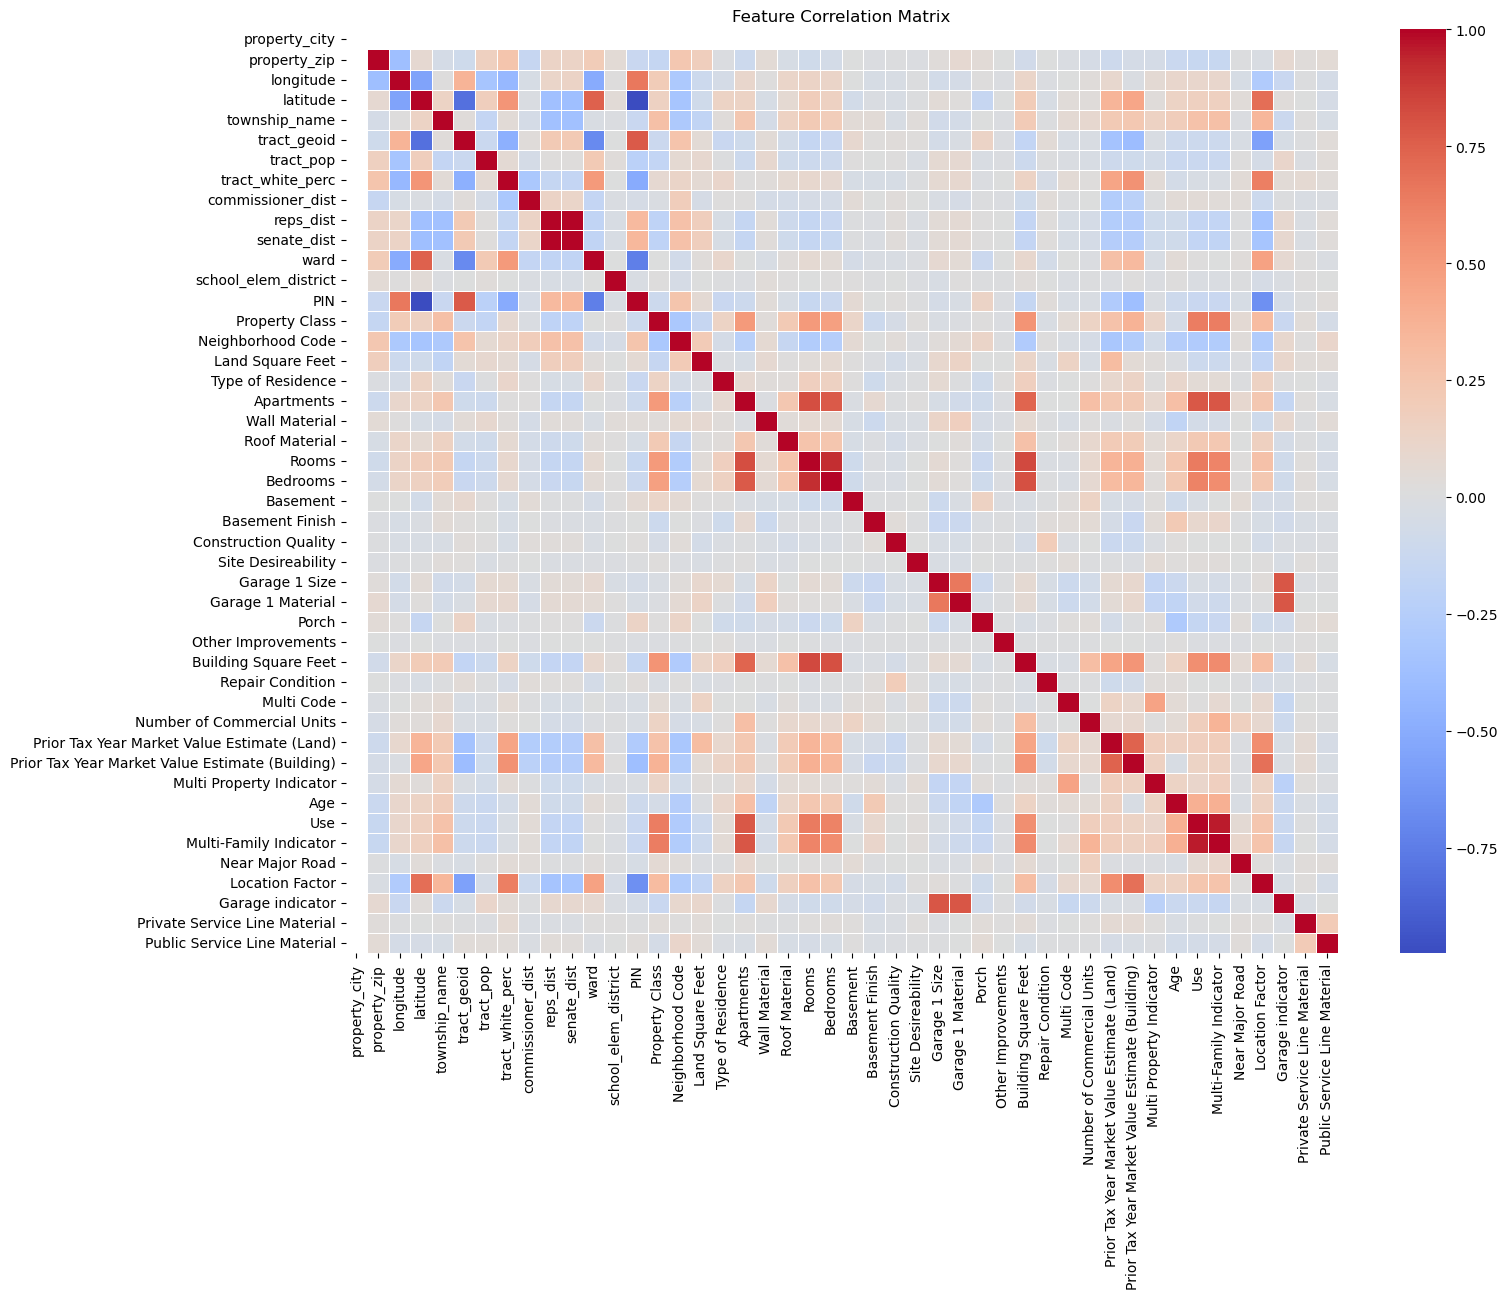

Private Service Line Material Distribution:
Private Service Line Material
NOT LEAD                            67.72242
LEAD                                32.27758
GALVANIZED REQUIRING REPLACEMENT     0.00000
SUSPECTED LEAD                       0.00000
Name: proportion, dtype: float64
Public Service Line Material Distribution:
Public Service Line Material
LEAD              55.227273
NOT LEAD          44.772727
SUSPECTED LEAD     0.000000
Name: proportion, dtype: float64


In [10]:
# plot class distribution of 'Private Service Line Material'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='Private Service Line Material', order=df_cleaned['Private Service Line Material'].value_counts().index)
plt.title('Distribution of Private Service Line Material Classes')
plt.xticks(rotation=45)
plt.xlabel('Private Service Line Material')
plt.ylabel('Count')
plt.show()

# plot class distribution of 'Public Service Line Material'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='Public Service Line Material', order=df_cleaned['Public Service Line Material'].value_counts().index)
plt.title('Distribution of Public Service Line Material Classes')
plt.xticks(rotation=45)
plt.xlabel('Public Service Line Material')
plt.ylabel('Count')
plt.show()

# plot distribution for township name
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='township_name', order=df_cleaned['township_name'].value_counts().index)
plt.title('Distribution of Township Name')
plt.xticks(rotation=45)
plt.xlabel('Township Name')
plt.ylabel('Count')
plt.show()


# generate correlation matrix for numerical features
# convert categorical data back to numeric codes if necessary
df_numeric = df_cleaned.copy()

# drop non-numeric columns
df_numeric = df_numeric.select_dtypes(include=['int64', 'float64', 'category'])

# convert categorical columns to numeric codes for correlation
for col in df_numeric.select_dtypes(include=['category']).columns:
    df_numeric[col] = df_numeric[col].cat.codes

# compute the correlation matrix
correlation_matrix = df_numeric.corr()

# plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()


# get class distribution percentages for rows labeled 'LEAD' and 'NOT LEAD' for both 'Private Service Line Material' and 'Public Service Line Material'
# Private Service Line Material
df_lead = df_cleaned[df_cleaned['Private Service Line Material'].isin(['LEAD', 'NOT LEAD'])]
lead_distribution = df_lead['Private Service Line Material'].value_counts(normalize=True) * 100
print("Private Service Line Material Distribution:")
print(lead_distribution)

# Public Service Line Material
df_lead = df_cleaned[df_cleaned['Public Service Line Material'].isin(['LEAD', 'NOT LEAD'])]
lead_distribution = df_lead['Public Service Line Material'].value_counts(normalize=True) * 100
print("Public Service Line Material Distribution:")
print(lead_distribution)



In [11]:
# for our models, we will only train on rows where the Private/Public Service Line materia is LEAD or NOT LEAD
# drop rows where the service line material is not lead or lead
df_cleaned = df_cleaned[df_cleaned['Private Service Line Material'].isin(['LEAD', 'NOT LEAD'])]
df_cleaned = df_cleaned[df_cleaned['Public Service Line Material'].isin(['LEAD', 'NOT LEAD'])]

Naive Bayes Classifier for Private Service Line Material
Accuracy: 0.7875816993464052
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.79      0.56        52
           1       0.95      0.79      0.86       254

    accuracy                           0.79       306
   macro avg       0.69      0.79      0.71       306
weighted avg       0.86      0.79      0.81       306



/Users/rajansavani/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/rajansavani/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/rajansavani/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 10 are removed. Consider decreasing the number of bins.
  warnings.warn(


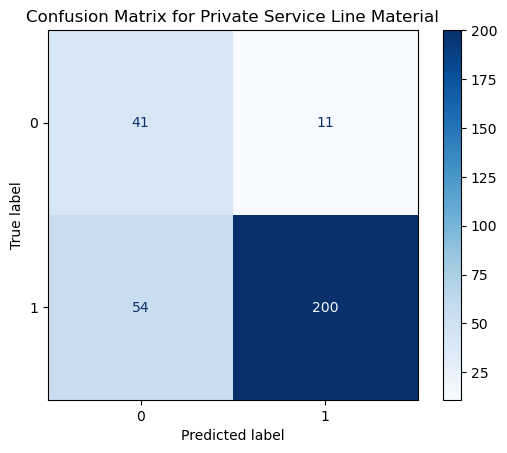

Naive Bayes Classifier for Public Service Line Material
Accuracy: 0.7745098039215687
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76       132
           1       0.84      0.74      0.79       174

    accuracy                           0.77       306
   macro avg       0.77      0.78      0.77       306
weighted avg       0.78      0.77      0.78       306



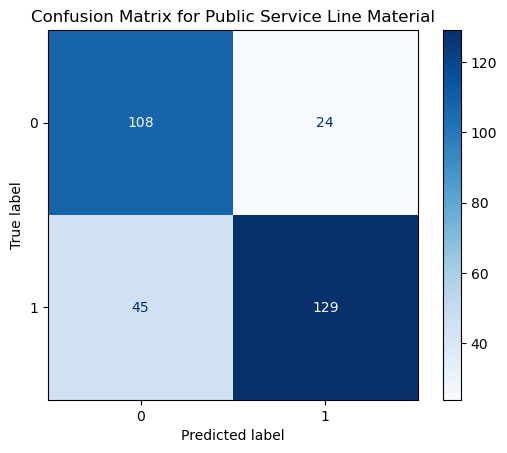

In [12]:
# NAIVE BAYES CLASSIFIER
# build two models, one for public and one for private service line material

# create a copy for Naive Bayes
df_nb = df_cleaned.copy()

# identify numerical columns that are not already categorical
numerical_columns = df_nb.select_dtypes(include=['int64', 'float64']).columns

# initialize discretizer
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df_nb[numerical_columns] = discretizer.fit_transform(df_nb[numerical_columns])

# convert binned numerical columns to categorical
for col in numerical_columns:
    df_nb[col] = df_nb[col].astype('category')

# prepare features and encode categorical variables
def prepare_data(df, target_column):
    X = df.drop(columns=[target_column, 'Date']) # drop target column and date because CategoricalNB does not work with datetime objects
    y = df[target_column]

    # encode categorical features
    encoders = {}
    for col in X.select_dtypes(include=['category', 'object']).columns: # select only categorical columns
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str)) # convert to string to handle missing values
        encoders[col] = le

    # encode target variable
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y.astype(str))
    
    return X, y, encoders, target_encoder

# function to train and evaluate the Naive Bayes classifier
def train_naive_bayes(X, y, target_name):
    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1738, stratify=y)
    
    # initialize and train the Naive Bayes classifier
    model = CategoricalNB()
    model.fit(X_train, y_train)
    
    # predictions and evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Naive Bayes Classifier for {target_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix for {target_name}')
    plt.show()
    
# build and evaluate classifiers for Private and Public Service Line Material
X_private, y_private, encoders_private, target_encoder_private = prepare_data(df_nb, 'Private Service Line Material')
train_naive_bayes(X_private, y_private, 'Private Service Line Material')

X_public, y_public, encoders_public, target_encoder_public = prepare_data(df_nb, 'Public Service Line Material')
train_naive_bayes(X_public, y_public, 'Public Service Line Material')

k-NN Classifier for Private Service Line Material
Accuracy: 0.8202614379084967
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.35      0.40        52
           1       0.87      0.92      0.89       254

    accuracy                           0.82       306
   macro avg       0.67      0.63      0.65       306
weighted avg       0.80      0.82      0.81       306



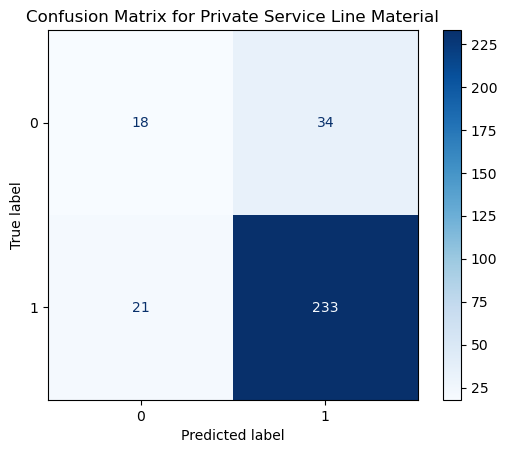

k-NN Classifier for Public Service Line Material
Accuracy: 0.6830065359477124
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.64      0.64       132
           1       0.73      0.71      0.72       174

    accuracy                           0.68       306
   macro avg       0.68      0.68      0.68       306
weighted avg       0.68      0.68      0.68       306



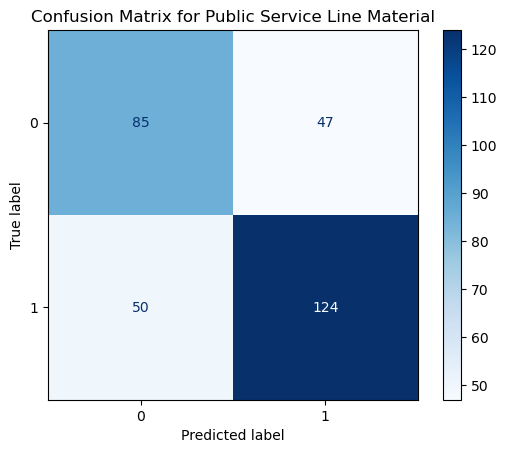

In [13]:
# k-NEAREST NEIGHBORS CLASSIFIER
# create a copy for k-NN
df_knn = df_cleaned.copy()

# select numerical columns
numerical_columns = df_knn.select_dtypes(include=['int64', 'float64']).columns

# scale numerical features
scaler = StandardScaler()
df_knn[numerical_columns] = scaler.fit_transform(df_knn[numerical_columns])

# prepare features and encode categorical variables
def prepare_knn_data(df, target_column):
    X = df.drop(columns=[target_column, 'Date'])  # Drop target column & Date
    y = df[target_column]

    # encode categorical variables
    encoders = {}
    for col in X.select_dtypes(include=['category', 'object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))  # convert to string for handling missing values
        encoders[col] = le

    # encode target variable
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y.astype(str))
    
    return X, y, encoders, target_encoder, scaler

# prepare k-NN data
X_private_knn, y_private_knn, encoders_private_knn, target_encoder_private_knn, scaler_private = prepare_knn_data(df_knn, 'Private Service Line Material')
X_public_knn, y_public_knn, encoders_public_knn, target_encoder_public_knn, scaler_public = prepare_knn_data(df_knn, 'Public Service Line Material')

def train_knn(X, y, target_name, n_neighbors=5):
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1738, stratify=y)

    # reapply standard scaling on training & test sets
    scaler = StandardScaler()
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

    # convert to NumPy arrays to avoid c_contiguous error
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    # train k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)

    # make predictions
    y_pred = knn.predict(X_test)

    # evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"k-NN Classifier for {target_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix for {target_name}')
    plt.show()


# train k-NN on Private and Public Service Line Material
train_knn(X_private_knn, y_private_knn, 'Private Service Line Material', n_neighbors=7)
train_knn(X_public_knn, y_public_knn, 'Public Service Line Material', n_neighbors=7)
